In [91]:
!pip install tensorflow opencv-python-headless matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable


In [92]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [93]:
import os

# Définir le chemin vers le dossier du dataset
dataset_dir = './car-brand-logos'
kaggle_dest = os.path.expanduser('~/.kaggle')
kaggle_json_path = os.path.join(kaggle_dest, 'kaggle.json')

# Vérifier si le dossier car-brand-logos existe
if not os.path.exists(dataset_dir):
    # Créer le dossier .kaggle et placer votre fichier kaggle.json (API token) si nécessaire
    os.makedirs(kaggle_dest, exist_ok=True)
    
    if not os.path.exists(kaggle_json_path):
        os.system('cp kaggle.json ~/.kaggle/')
        os.system('chmod 600 ~/.kaggle/kaggle.json')

    # Télécharger le dataset "car-brand-recognition" depuis Kaggle

    #https://www.kaggle.com/datasets/hadyfarrag/car-brand-recognition
    #https://www.kaggle.com/datasets/yamaerenay/100-images-of-top-50-car-brands
    #https://www.kaggle.com/datasets/volkandl/car-brand-logos
    username = 'volkandl'
    dataset_name = 'car-brand-logos'
    os.system(f'kaggle datasets download -d {username}/{dataset_name}')

    # Créer le dossier pour la décompression
    os.makedirs(dataset_dir, exist_ok=True)

    # Décompresser le fichier zip téléchargé dans le dossier car-brand-logos
    os.system(f'unzip -q {dataset_name}.zip -d {dataset_dir}')

    print("Le dataset a été téléchargé et décompressé.")
else:
    print("Le dossier car-brand-logos existe déjà. Aucune action n'a été effectuée.")

Le dossier car-brand-logos existe déjà. Aucune action n'a été effectuée.


In [94]:
import cv2
import matplotlib.pyplot as plt
import pathlib
import random

# Définir les chemins vers les ensembles d'entraînement et de test
train_dir = pathlib.Path('./car-brand-logos/Car_Brand_Logos/Train')
test_dir = pathlib.Path('./car-brand-logos/Car_Brand_Logos/Test') 

# Récupérer les sous-dossiers (marques) dans l'ensemble d'entraînement
train_brands = [brand for brand in train_dir.iterdir() if brand.is_dir()]

# Sélectionner deux marques aléatoires
random_brands = random.sample(train_brands, 2)
brand1, brand2 = random_brands[0], random_brands[1]

print(f"Marques sélectionnées aléatoirement : {brand1.name}, {brand2.name}")




Marques sélectionnées aléatoirement : opel, hyundai


In [95]:
# Charger quelques images de chaque modèle de voiture pour les marques sélectionnées aléatoirement
brand1_images_train = list(brand1.glob('*'))
brand2_images_train = list(brand2.glob('*'))



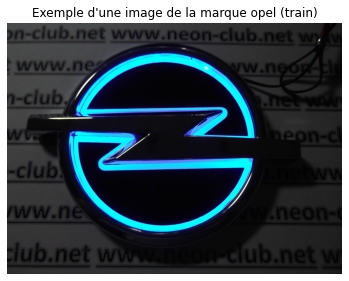

In [96]:
# Charger et afficher une image aléatoire de la première marque sélectionnée (train set)
if len(brand1_images_train) > 0:
    random_brand1_image = random.choice(brand1_images_train)  # Sélection aléatoire
    img_brand1 = cv2.imread(str(random_brand1_image))
    img_brand1 = cv2.cvtColor(img_brand1, cv2.COLOR_BGR2RGB)  # Conversion en RGB pour affichage

    plt.figure(figsize=(6, 6))
    plt.imshow(img_brand1)
    plt.title(f"Exemple d'une image de la marque {brand1.name} (train)")
    plt.axis('off')
    plt.show()
else:
    print(f"Aucune image de la marque '{brand1.name}' n'a été trouvée dans l'ensemble d'entraînement.")


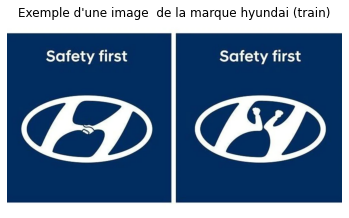

In [97]:

# Charger et afficher une image aléatoire de la deuxième marque sélectionnée (train set)
if len(brand2_images_train) > 0:
    random_brand2_image = random.choice(brand2_images_train)  # Sélection aléatoire
    img_brand2 = cv2.imread(str(random_brand2_image))
    img_brand2 = cv2.cvtColor(img_brand2, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_brand2)
    plt.title(f"Exemple d'une image  de la marque {brand2.name} (train)")
    plt.axis('off')
    plt.show()
else:
    print(f"Aucune image de la marque '{brand2.name}' n'a été trouvée dans l'ensemble d'entraînement.")

**Équilibrage des classes**

***Objectif*** : Vérifier la distribution des images pour chaque marque de voiture et utiliser des techniques d'augmentation de données si nécessaire pour rééquilibrer les classes.

***Étapes*** :

Vérification de la distribution des classes : Compter le nombre d'images pour chaque marque et vérifier s'il y a un déséquilibre (par exemple, certaines marques ayant beaucoup plus d'images que d'autres).

Augmentation des données : Si certaines classes ont moins d'images, on peut augmenter artificiellement la quantité d'images en appliquant des transformations comme des rotations, des inversions horizontales, etc.

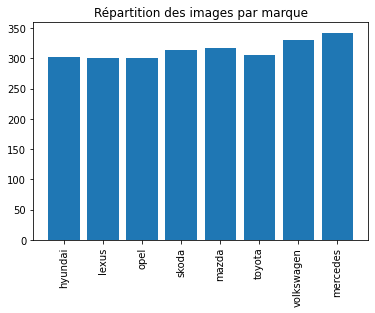

In [98]:
import os
import matplotlib.pyplot as plt

# Compter le nombre d'images pour chaque marque
class_counts = {}
for brand in os.listdir(train_dir):
    brand_path = os.path.join(train_dir, brand)
    if os.path.isdir(brand_path):
        class_counts[brand] = len(os.listdir(brand_path))

# Afficher la distribution des classes
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Répartition des images par marque")
plt.show()


### Prétraitement des images

***Objectif*** : Assurer une uniformité des dimensions et des formats pour que toutes les images aient la même taille, soit dans un format RGB, et qu'elles soient prêtes à être utilisées dans le modèle.

***Étapes***:

Redimensionnement : Toutes les images doivent avoir la même taille (par exemple, 224x224 pixels), une exigence pour les modèles CNN.

Conversion des couleurs : Certaines images peuvent être en niveaux de gris ou avoir des canaux de couleur différents. Il est recommandé de convertir toutes les images en format RGB (3 canaux).

Normalisation des pixels : Diviser les valeurs de pixels par 255 pour les ramener dans une plage de [0, 1], ce qui facilite l'entraînement du modèle.


<!--
 Copyright 2024 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



In [99]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Définir les paramètres
img_height = 224
img_width = 224
batch_size = 32

# Initialiser ImageDataGenerator pour l'entraînement avec redimensionnement et normalisation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des valeurs de pixels
    validation_split=0.2  # Séparation des données pour validation (20%)
)







In [100]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration des générateurs avec validation_split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Spécifiez le pourcentage pour la validation
)


# Générateur pour les données d'entraînement
train_data = datagen.flow_from_directory(
    './car-brand-logos/Car_Brand_Logos/Train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # Utiliser pour l'entraînement
    seed=42
)

# Générateur pour les données de validation
val_data = datagen.flow_from_directory(
    './car-brand-logos/Car_Brand_Logos/Train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Utiliser pour la validation
    seed=42
)


Found 2013 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


In [101]:

"""# Charger les images d'entraînement
train_data = train_datagen.flow_from_directory(
    './car_brand_detection_Dataset/standford_beta/train',
    target_size=(img_height, img_width),  # Redimensionnement des images
    batch_size=batch_size,
    class_mode='categorical',  # Classification multi-classes
    subset='training',  # Utiliser les images pour l'entraînement
    seed=42  # Assurer une séparation consistante
)

# Charger les images de validation
val_data = train_datagen.flow_from_directory(
    './car_brand_detection_Dataset/standford_beta/train',  # Même répertoire, mais pour la validation
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Utiliser les images pour la validation
    seed=42
)"""





"# Charger les images d'entraînement\ntrain_data = train_datagen.flow_from_directory(\n    './car_brand_detection_Dataset/standford_beta/train',\n    target_size=(img_height, img_width),  # Redimensionnement des images\n    batch_size=batch_size,\n    class_mode='categorical',  # Classification multi-classes\n    subset='training',  # Utiliser les images pour l'entraînement\n    seed=42  # Assurer une séparation consistante\n)\n\n# Charger les images de validation\nval_data = train_datagen.flow_from_directory(\n    './car_brand_detection_Dataset/standford_beta/train',  # Même répertoire, mais pour la validation\n    target_size=(img_height, img_width),\n    batch_size=batch_size,\n    class_mode='categorical',\n    subset='validation',  # Utiliser les images pour la validation\n    seed=42\n)"

In [102]:
# Charger les images de test (sans division en validation)
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation des pixels

test_data = test_datagen.flow_from_directory(
    './car-brand-logos/Car_Brand_Logos/Test',  # Répertoire des données de test
    target_size=(img_height, img_width),  # Redimensionner les images
    batch_size=batch_size,
    class_mode='categorical',  # Pour classification multi-classes
    seed=42  # Graine pour la reproductibilité
)



Found 400 images belonging to 8 classes.


La **data augmentation** est une technique utilisée principalement dans le domaine de l'apprentissage automatique pour augmenter artificiellement la taille d'un ensemble de données d'entraînement en créant des versions modifiées des données existantes. Voici les points clés à comprendre :

### But de la Data Augmentation
- **Augmenter la taille de l'ensemble de données** : Elle permet de créer de nouvelles données d'entraînement à partir des données existantes en appliquant des transformations qui conservent les labels des données. Cela est particulièrement utile lorsque les données originales sont limitées.
- **Améliorer la généralisation du modèle** : En exposant le modèle à diverses variations des données d'entraînement, cela l'aide à mieux généraliser à de nouvelles données inédites, réduisant ainsi le risque de surapprentissage.

### Problèmes Résolus
- **Surapprentissage** : Dans les cas où un modèle apprend trop spécifiquement les détails de l'ensemble d'entraînement, il peut mal performer sur de nouvelles données. La data augmentation aide à prévenir cela en diversifiant les données d'entraînement.
- **Manque de données** : Elle est particulièrement utile quand il est difficile ou coûteux d'obtenir plus de données d'entraînement.

### Applications
- **Sur des images** : Rotation, redimensionnement, recadrage, ajustement de la luminosité, du contraste, etc.
- **Sur du texte** : Utilisation de synonymes, inversion de phrases, traduction aller-retour, etc.
- **Sur des données audio** : Modifications de la vitesse, du ton, ajout de bruit de fond.

### Quand l'Appliquer
- **Pendant l'entraînement** : Elle est généralement appliquée en temps réel pendant l'entraînement d'un modèle. Des frameworks comme TensorFlow et PyTorch permettent d'intégrer facilement l'augmentation des données dans le processus d'entraînement.
- **Non recommandée pour les ensembles de test** : Pour évaluer la performance d'un modèle, il est important d'utiliser des données non modifiées pour voir comment le modèle fonctionne avec de nouvelles données réalistes.



In [103]:
import matplotlib.pyplot as plt

# Récupérer les classes du générateur
class_names = train_data.class_indices  # Dictionnaire de classes {marque: index}
inverse_class_names = {v: k for k, v in class_names.items()}  # Inverser le dictionnaire pour obtenir {index: marque}

# Afficher quelques exemples d'images prétraitées du jeu d'entraînement
sample_batch = next(train_data)
images, labels = sample_batch



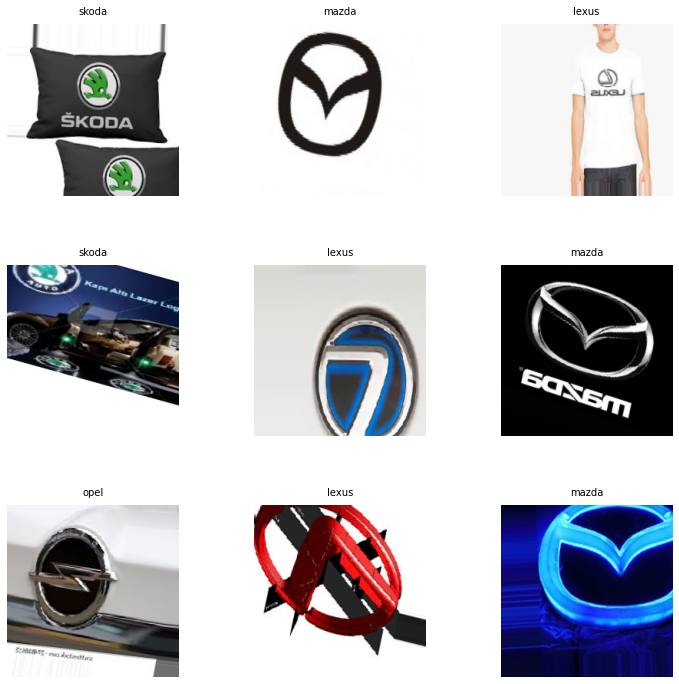

In [104]:
# Créer la figure
plt.figure(figsize=(12, 12))

for i in range(9):  # Afficher 9 exemples
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    # Récupérer le nom de la marque à partir du label
    label_index = labels[i].argmax()  # Trouver l'indice de la classe avec la plus grande probabilité
    plt.title(inverse_class_names[label_index], fontsize=10, pad=10)  # Utiliser cet indice pour afficher le nom de la classe avec un peu d'espace
    plt.axis('off')

# Ajuster les espaces entre les sous-graphes pour éviter le chevauchement des titres
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # hspace et wspace ajustent l'espace vertical et horizontal

plt.show()



**Définition de l'architecture CNN**

<!--
 Copyright 2024 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



***methode 1***

In [105]:
"""num_classes = len(os.listdir(train_dir))
from tensorflow.keras import layers, models

# Définir l'architecture du modèle CNN
model = models.Sequential([

    # Étape de rescaling pour normaliser les pixels (valeurs entre 0 et 1)
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Correction ici  
    
    # Première couche de convolution
    layers.Conv2D(128, (4, 4), activation='relu'),  # 128 filtres, noyau 4x4, activation ReLU
    layers.MaxPooling2D(),  # Réduction de la taille de la carte avec MaxPooling
    
    # Deuxième couche de convolution
    layers.Conv2D(64, (4, 4), activation='relu'),  # 64 filtres, noyau 4x4, activation ReLU
    layers.MaxPooling2D(),  # Réduction de la taille de la carte avec MaxPooling
    
    # Troisième couche de convolution
    layers.Conv2D(32, (4, 4), activation='relu'),  # 32 filtres, noyau 4x4, activation ReLU
    layers.MaxPooling2D(),  # Réduction de la taille de la carte avec MaxPooling
    
    # Quatrième couche de convolution
    layers.Conv2D(16, (4, 4), activation='relu'),  # 16 filtres, noyau 4x4, activation ReLU
    layers.MaxPooling2D(),  # Réduction de la taille de la carte avec MaxPooling
    
    # Aplatir la carte de caractéristiques (Flatten) pour passer à la couche dense
    layers.Flatten(),
    
    # Couche dense avec 64 neurones et activation ReLU
    layers.Dense(64, activation='relu'),
    
    # Couche de sortie : nombre de neurones égal au nombre de classes, avec softmax pour la classification multi-classes
    layers.Dense(num_classes, activation='softmax')  
])

# Afficher le résumé du modèle
model.summary()
"""

"num_classes = len(os.listdir(train_dir))\nfrom tensorflow.keras import layers, models\n\n# Définir l'architecture du modèle CNN\nmodel = models.Sequential([\n\n    # Étape de rescaling pour normaliser les pixels (valeurs entre 0 et 1)\n    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Correction ici  \n    \n    # Première couche de convolution\n    layers.Conv2D(128, (4, 4), activation='relu'),  # 128 filtres, noyau 4x4, activation ReLU\n    layers.MaxPooling2D(),  # Réduction de la taille de la carte avec MaxPooling\n    \n    # Deuxième couche de convolution\n    layers.Conv2D(64, (4, 4), activation='relu'),  # 64 filtres, noyau 4x4, activation ReLU\n    layers.MaxPooling2D(),  # Réduction de la taille de la carte avec MaxPooling\n    \n    # Troisième couche de convolution\n    layers.Conv2D(32, (4, 4), activation='relu'),  # 32 filtres, noyau 4x4, activation ReLU\n    layers.MaxPooling2D(),  # Réduction de la taille de la carte avec MaxPooling\n    \n    # Quatrième cou

***methode 2***

In [106]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [107]:
# Set Resize variable
IMAGE_SIZE = [224, 224] # This is my desired image size... and also ResNet50 accepts image of 224*224.

# Configuration de base du modèle
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in resnet.layers[:-10]:  # Rendre entraînables les 10 dernières couches(fine_tuning)
    layer.trainable = False
    


In [108]:
    
# Usefule for getting number of output classes.
folders =[brand for brand in train_dir.iterdir() if brand.is_dir()]
folders



[PosixPath('car-brand-logos/Car_Brand_Logos/Train/hyundai'),
 PosixPath('car-brand-logos/Car_Brand_Logos/Train/lexus'),
 PosixPath('car-brand-logos/Car_Brand_Logos/Train/opel'),
 PosixPath('car-brand-logos/Car_Brand_Logos/Train/skoda'),
 PosixPath('car-brand-logos/Car_Brand_Logos/Train/mazda'),
 PosixPath('car-brand-logos/Car_Brand_Logos/Train/toyota'),
 PosixPath('car-brand-logos/Car_Brand_Logos/Train/volkswagen'),
 PosixPath('car-brand-logos/Car_Brand_Logos/Train/mercedes')]

In [109]:
# List all brand folders
folders = [brand for brand in train_dir.iterdir() if brand.is_dir()]

# Collect brand names from each folder
brand_names = [folder.name for folder in folders]  # Use folder.name to get just the folder names

brand_names



['hyundai',
 'lexus',
 'opel',
 'skoda',
 'mazda',
 'toyota',
 'volkswagen',
 'mercedes']

In [110]:
brand_names = [brand.name for brand in folders]
print(brand_names)



['hyundai', 'lexus', 'opel', 'skoda', 'mazda', 'toyota', 'volkswagen', 'mercedes']


In [ ]:
num_classes = len(brand_names)


In [111]:
# Set the flatten layer.
#x = Flatten() (resnet.output) # joue le meme role que  GlobalAveragePooling2D

# Ajout des nouvelles couches
x = GlobalAveragePooling2D()(resnet.output)
"""# Ajout des nouvelles couches
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
num_classes = len(brand_names)  # 'num_classes' est le nombre de classes
x = Dense(num_classes, activation='softmax')(x)  # Couche de sortie"""


In [112]:


prediction = Dense(len(folders), activation='softmax')(x)


In [113]:
# Create a model Object

model = Model(inputs=resnet.input, outputs=prediction)


In [114]:
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,604,104 (90.04 MB)

 Trainable params: 4,482,056 (17.10 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

**Compilateur et fonction de perte**

In [115]:

model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Un taux d'apprentissage ajusté
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


"""model.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.0001),  # Un taux d'apprentissage ajusté
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
"""


In [116]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import os

# Assurer que le répertoire du log est bien défini
logdir = "logs"
if not os.path.exists(logdir):
    os.makedirs(logdir)


# Configuration des callbacks TensorBoard
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_images=True)

# Callback pour arrêter l'entraînement lorsque le score de validation ne s'améliore plus
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Callback pour réduire le taux d'apprentissage lorsque le plateau de la métrique 'val_loss' est atteint
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


# Callback pour sauvegarder le meilleur modèle pendant l'entraînement
model_checkpoint = callbacks.ModelCheckpoint(
    filepath=os.path.join(logdir, 'best_model.keras'),  # Change file extension to `.keras`
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)


# Entraîner le modèle avec les callbacks configurés
history = model.fit( 
    train_data,
    validation_data=val_data,
    epochs=20,  # Augmenter le nombre d'époques si le modèle continue de s'améliorer
    callbacks=[tensorboard_callback, early_stopping, reduce_lr, model_checkpoint]
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.1887 - loss: 2.1302 - val_accuracy: 0.1280 - val_loss: 2.5179 - learning_rate: 1.0000e-04
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.3308 - loss: 1.8179 - val_accuracy: 0.2040 - val_loss: 2.0896 - learning_rate: 1.0000e-04
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.4149 - loss: 1.6595 - val_accuracy: 0.2420 - val_loss: 2.0572 - learning_rate: 1.0000e-04
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.4368 - loss: 1.5462 - val_accuracy: 0.2620 - val_loss: 2.0713 - learning_rate: 1.0000e-04
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.4648 - loss: 1.5211 - val_accuracy: 0.3540 - val_loss: 1.7752 - learning_rate: 1.0000e-04
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.4935 - loss: 1.4381 - val_accuracy: 0.3500 - val_loss: 1.8282 - learning_rate: 1.0000e-04
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4983 

<!--
 Copyright 2024 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



**Visualisation des performances**

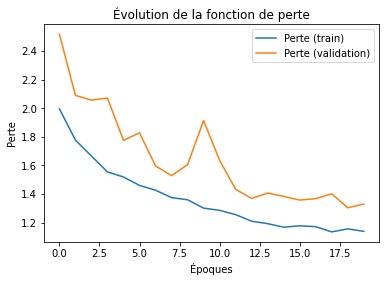

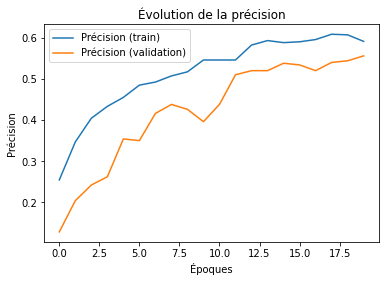

In [117]:
import matplotlib.pyplot as plt

# Visualiser l'évolution de la perte
plt.plot(history.history['loss'], label='Perte (train)')
plt.plot(history.history['val_loss'], label='Perte (validation)')
plt.title('Évolution de la fonction de perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

# Visualiser l'évolution de la précision
plt.plot(history.history['accuracy'], label='Précision (train)')
plt.plot(history.history['val_accuracy'], label='Précision (validation)')
plt.title('Évolution de la précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.show()


***prediction***

In [118]:

# Récupérer les noms des classes à partir du générateur de données
class_names = list(train_data.class_indices.keys())


In [121]:
class_names

['hyundai',
 'lexus',
 'mazda',
 'mercedes',
 'opel',
 'skoda',
 'toyota',
 'volkswagen']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


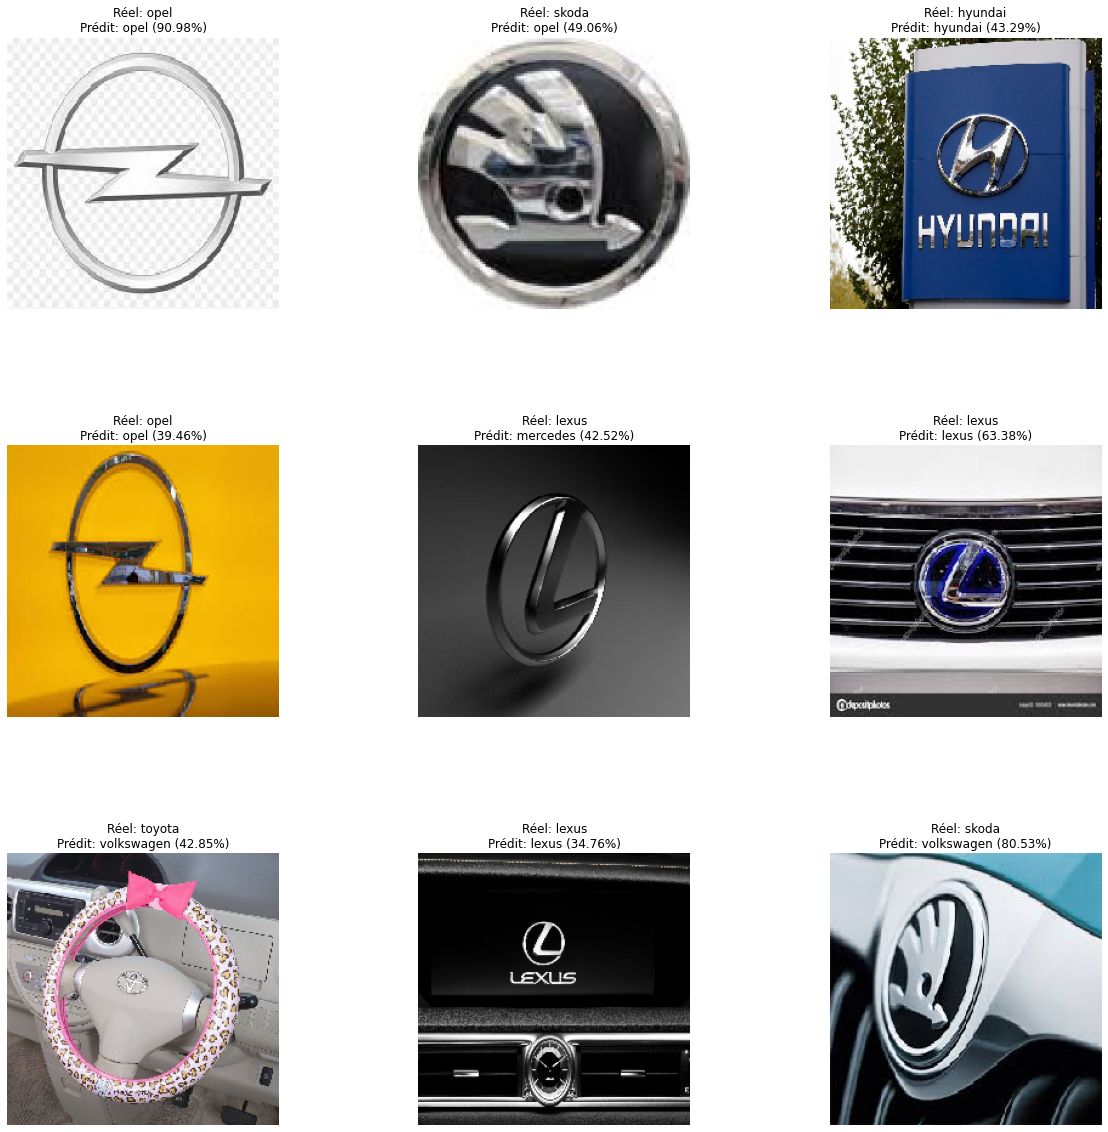

In [119]:
inverse_class_names = {v: k for k, v in train_data.class_indices.items()}  # Inverser le dictionnaire

plt.figure(figsize=(20, 20))
for images_batch, labels_batch in test_data:
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = (images_batch[i] * 255).astype("uint8") if images_batch[i].dtype == np.float32 else images_batch[i]

        plt.imshow(img)
        plt.axis('off')
        
        # Prédire la classe pour l'image
        batch_prediction = model.predict(np.expand_dims(images_batch[i], axis=0))
        predicted_class_index = np.argmax(batch_prediction[0])
        predicted_class_name = inverse_class_names[predicted_class_index]
        confidence = round(100 * np.max(batch_prediction[0]), 2)
        
        # Obtenir le label réel de l'image
        actual_class_index = np.argmax(labels_batch[i])
        actual_class_name = inverse_class_names[actual_class_index]
        
        plt.title(f"Réel: {actual_class_name}\nPrédit: {predicted_class_name} ({confidence}%)")
    
    plt.subplots_adjust(hspace=0.5, wspace=0.4)
    plt.show()
    break  # Afficher seulement le premier batch

In [1]:
import tensorflow as tf
import os

def save_model(model, model_path):
    """Sauvegarde le modèle au chemin spécifié."""
    try:
        model.save(model_path)
        print(f"Modèle sauvegardé avec succès à {model_path}.")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde du modèle : {e}")

def load_model_from_path(model_path):
    """Charge le modèle à partir du chemin spécifié."""
    if os.path.exists(model_path):
        try:
            model = tf.keras.models.load_model(model_path)
            print(f"Modèle chargé avec succès depuis {model_path}.")
            return model
        except Exception as e:
            print(f"Erreur lors du chargement du modèle : {e}")
            return None
    else:
        print(f"Le fichier {model_path} n'existe pas.")
        return None

# Utilisation
model_path = "model.h5"

# Sauvegarder le modèle
save_model(model, model_path)

# Charger le modèle
loaded_model = load_model_from_path(model_path)

2024-10-19 11:45:48.553980: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-19 11:45:48.563613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 11:45:48.574979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 11:45:48.578643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 11:45:48.588512: I tensorflow/core/platform/cpu_feature_guar

NameError: name 'model' is not defined